In [1]:
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('chesterish')

In [9]:
import torch
import torchvision.datasets as datasets
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
from livelossplot import PlotLosses
import numpy as np

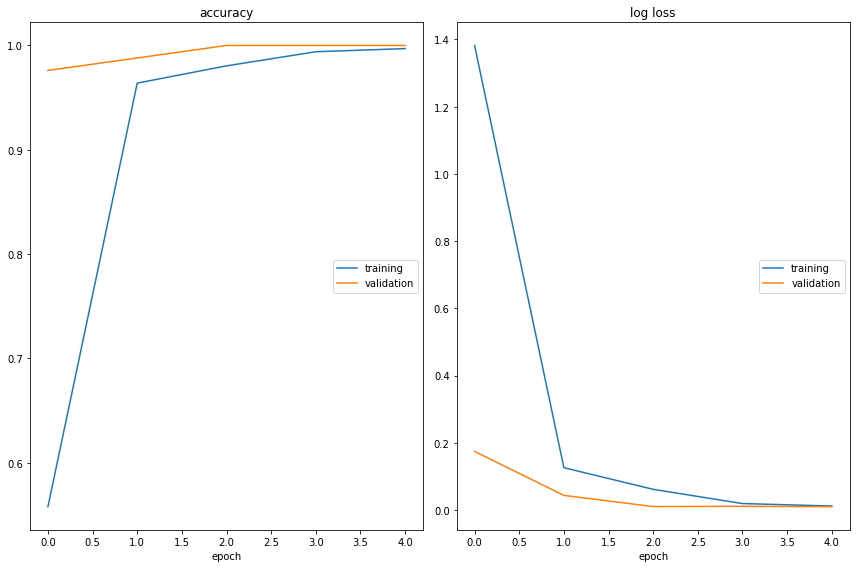

accuracy
	training         	 (min:    0.558, max:    0.997, cur:    0.997)
	validation       	 (min:    0.976, max:    1.000, cur:    1.000)
log loss
	training         	 (min:    0.012, max:    1.382, cur:    0.012)
	validation       	 (min:    0.010, max:    0.174, cur:    0.010)


In [10]:
# Import the dataset
dataset = datasets.ImageFolder('/Volumes/KURAPIKA4/Study/Dataset/Butterfly/segmentation', 
        transforms.Compose([transforms.Resize((224, 224)),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))

# Split the dataset into training set and test set (80:20)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, 
    [int(len(dataset)*.8), len(dataset)-int(len(dataset)*.8)], 
    generator=torch.Generator().manual_seed(44))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True, 
                                           num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 128, shuffle = True, 
                                          num_workers=0)

dataloaders = {'train': train_loader, 'validation': test_loader}

# Load the pretrained model    
model = models.alexnet(pretrained = True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10) # replace 
# output layer to have only 10 classes
print(model.eval())

# Set the training parameters
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

# Train the network
train_accu = []
train_losses = []
val_accu = []
val_losses = []
liveloss = PlotLosses()
for epoch in range(5):
    logs = {}
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
            
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in dataloaders[phase]:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            _, preds = torch.max(outputs, 1)
            running_loss += loss.detach() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
                
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
        prefix = ''
        print(epoch_loss)
        print(epoch_acc)
        train_accu.append(100*epoch_acc.item())
        train_losses.append(epoch_loss.item())
        if phase == 'validation':
            prefix = 'val_'

        logs[prefix + 'log loss'] = epoch_loss.item()
        logs[prefix + 'accuracy'] = epoch_acc.item()
    
    liveloss.update(logs)
    liveloss.send()